# LincWare — AI/ML Take-Home: Cryptocurrency Dataset
**Author:** Your Name  
**Role Targeted:** AI/ML Engineer / Data Scientist  
**Repo/Notebook Intent:** Clear reasoning → Reproducible code → Measurable results

---

## Problem 1 — Cryptocurrency Insights and Exploratory Analysis  

### Objective  
Analyze the `cryptocurrency.csv` dataset to extract key market insights, visualize performance metrics, and identify potential investment opportunities.

### Tasks  
1. **Data Cleaning & Preparation**  
   - Remove duplicates and invalid numeric entries.  
   - Convert string-encoded numbers (e.g., `$12,345`, `5.3%`) into floats.  
   - Derive useful metrics such as `volume_to_market_cap` (liquidity ratio).  

2. **Exploratory Analysis**  
   - Find the **Top 10 cryptocurrencies by market cap**.  
   - Identify coins with the **highest 7-day growth**.  
   - Determine coins with the **highest trading volume relative to market cap**.  
   - Detect the **most volatile coins**, using absolute 24 h and 7 d percentage changes.  

3. **Visualization & Insight Generation**  
   - Create at least **3 charts**:
     - Bar chart – Top 10 by Market Cap.  
     - Scatter plot – Market Cap vs Price (log-scale).  
     - Custom chart – Liquidity vs 7-Day Growth or any other notable pattern.  
   - Interpret visual findings and highlight meaningful market behaviors.  

4. **Investment Recommendations**  
   - Based on all analyses, **recommend 5 cryptocurrencies** that appear to be good investment candidates.  
   - **Justify each pick in 2–3 sentences**, considering:
     - **Growth trend:** sustained short-term momentum.  
     - **Volatility:** manageable risk vs reward.  
     - **Market Cap:** size and stability of the project.  
     - **Volume:** trading liquidity and investor activity.  

### Assumptions  
- `chg_24h` and `chg_7d` are expressed as percentage values.  
- All monetary figures are denominated in USD.  
- Any row with non-positive price or market cap is excluded.  

---

In [24]:
# ===============================================
# Problem 1 — Step 1: CLEANING & NORMALIZATION
# (Python 3.9-safe typing; no 'str | None')
# ===============================================

import re
import numpy as np
import pandas as pd
from typing import Optional, List, Dict

# ---- 0) Config ----
CSV_PATH = "cryptocurrency.csv"   # change if needed

# ---- 1) Helper: normalize header strings to snake_case ----
def _normalize_col(c: str) -> str:
    c = c.strip().lower()
    c = c.replace("%", "pct")                # keep semantics in header
    c = c.replace("/", "_per_").replace("-", "_").replace(" ", "_")
    c = "".join(ch if (ch.isalnum() or ch == "_") else "_" for ch in c)
    c = re.sub("_+", "_", c).strip("_")
    return c

# ---- 2) Helper: coerce numeric-like strings to float ----
def _to_float(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("$", "", regex=False)
         .str.replace("%", "", regex=False)
         .str.strip()
         .replace({"": np.nan})
         .pipe(pd.to_numeric, errors="coerce")
    )

# ---- 3) Load & header normalization ----
raw = pd.read_csv(CSV_PATH)
raw.columns = [_normalize_col(c) for c in raw.columns]

# ---- 4) Alias resolution -> standard schema ----
ALIASES: Dict[str, List[str]] = {
    "name":       ["name", "coin", "asset", "currency"],
    "symbol":     ["symbol", "ticker"],
    "price_usd":  ["price_usd", "price", "current_price", "last_price"],
    "market_cap": ["market_cap", "marketcap", "market_cap_usd"],
    "vol_24h":    ["vol_24h", "volume_24h", "total_volume", "volume_usd_24h", "volume"],
    "chg_24h":    ["chg_24h", "change_24h", "pct_change_24h", "price_change_percentage_24h", "change24h"],
    "chg_7d":     ["chg_7d", "change_7d", "pct_change_7d", "price_change_percentage_7d", "change7d"],
}

def _find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    # exact match first
    for c in candidates:
        if c in df.columns:
            return c
    # contains fallback (e.g., "market_cap_usd" contains "market_cap")
    for c in candidates:
        for col in df.columns:
            if c in col:
                return col
    return None

colmap: Dict[str, str] = {}
for std, cands in ALIASES.items():
    found = _find_col(raw, cands)
    if not found:
        raise ValueError(f"Missing required column for '{std}'. Tried aliases: {cands}")
    colmap[std] = found

# ---- 5) Build df with STANDARD columns only ----
df = raw.rename(columns={colmap[k]: k for k in colmap}).copy()

# ---- 6) Coerce numerics where appropriate ----
for c in ["price_usd", "market_cap", "vol_24h", "chg_24h", "chg_7d"]:
    df[c] = _to_float(df[c])

# ---- 7) Tidy identifiers ----
for c in ["name", "symbol"]:
    df[c] = df[c].astype(str).str.strip()

# ---- 8) Deduplicate by best available key ----
if {"symbol", "name"}.issubset(df.columns):
    df = df.drop_duplicates(subset=["symbol", "name"])
elif "symbol" in df.columns:
    df = df.drop_duplicates(subset=["symbol"])
elif "name" in df.columns:
    df = df.drop_duplicates(subset=["name"])

# ---- 9) Basic validity filters ----
df = df[(df["price_usd"] > 0) & (df["market_cap"] > 0)].reset_index(drop=True)

# ---- 10) Final sanity printouts (optional) ----
print("Resolved column mapping -> standard schema:")
for k, v in colmap.items():
    print(f"  {k:>10s}  <=  {v}")

print("\nData shape after cleaning:", df.shape)
print("\nHead:")
print(df.head(5).to_string(index=False))

# At this point:
#   • `df` has standardized columns: name, symbol, price_usd, market_cap, vol_24h, chg_24h, chg_7d
#   • values are numeric where expected
#   • duplicates removed & basic validity applied

Resolved column mapping -> standard schema:
        name  <=  name
      symbol  <=  symbol
   price_usd  <=  price_usd
  market_cap  <=  market_cap
     vol_24h  <=  vol_24h
     chg_24h  <=  chg_24h
      chg_7d  <=  chg_7d

Data shape after cleaning: (242, 9)

Head:
          timestamp               name     symbol  price_usd    vol_24h total_vol  chg_24h  chg_7d   market_cap
2025-10-08 12:43:56          LEO Token        leo       9.67   763587.0     0.00%     0.42    1.46 8.915958e+09
2025-10-08 12:43:56           MemeCore          m       2.08 15926173.0     0.00%     0.31  -14.00 3.511235e+09
2025-10-08 12:43:56      Wrapped stETH     wsteth    5449.02 21181333.0     0.01%    -4.16    7.09 1.765923e+10
2025-10-08 12:43:56 Wrapped Beacon ETH      wbeth    4837.58 30328896.0     0.01%    -4.18    7.12 1.578358e+10
2025-10-08 12:43:56       Figure Heloc figr_heloc       1.00 27721957.0     0.01%    -0.12   -3.73 1.286307e+10


In [25]:
# ===============================================
# Problem 1 — Step 2: FEATURE ENGINEERING
# -----------------------------------------------
# What this cell does:
# 1) Adds liquidity and risk features:
#       • volume_to_mcap   = vol_24h / market_cap
#       • volatility_score = mean(|chg_24h|, |chg_7d|)
# 2) Runs basic sanity checks so later cells won't crash.
# Assumes: df exists from Step 1 with columns
#   name, symbol, price_usd, market_cap, vol_24h, chg_24h, chg_7d
# ===============================================

import numpy as np
import pandas as pd

# ---- 1) Derived features ----
df["volume_to_mcap"] = np.where(df["market_cap"] > 0, df["vol_24h"] / df["market_cap"], np.nan)

# volatility = average absolute % change across 24h & 7d
have_24 = df["chg_24h"].notna()
have_7d = df["chg_7d"].notna()

if have_24.any() and have_7d.any():
    df["volatility_score"] = (df["chg_24h"].abs() + df["chg_7d"].abs()) / 2.0
elif have_24.any():
    df["volatility_score"] = df["chg_24h"].abs()
elif have_7d.any():
    df["volatility_score"] = df["chg_7d"].abs()
else:
    df["volatility_score"] = np.nan

# ---- 2) Sanity checks / quick diagnostics ----
needed = ["name","symbol","price_usd","market_cap","vol_24h","chg_24h","chg_7d","volume_to_mcap","volatility_score"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Unexpected: missing engineered columns {missing}")

print("Feature engineering complete.")
print("Null counts (key cols):")
print(df[needed].isna().sum().to_string())
print("\nSample rows:")
display(df[["name","symbol","price_usd","market_cap","vol_24h","chg_24h","chg_7d","volume_to_mcap","volatility_score"]].head(5))

Feature engineering complete.
Null counts (key cols):
name                0
symbol              0
price_usd           0
market_cap          0
vol_24h             0
chg_24h             0
chg_7d              3
volume_to_mcap      0
volatility_score    3

Sample rows:


,name,symbol,price_usd,market_cap,vol_24h,chg_24h,chg_7d,volume_to_mcap,volatility_score
0,LEO Token,leo,9.67,8.915958e+09,763587.0,0.42,1.46,0.000086,0.940
1,MemeCore,m,2.08,3.511235e+09,15926173.0,0.31,-14.00,0.004536,7.155
2,Wrapped stETH,wsteth,5449.02,1.765923e+10,21181333.0,-4.16,7.09,0.001199,5.625
3,Wrapped Beacon ETH,wbeth,4837.58,1.578358e+10,30328896.0,-4.18,7.12,0.001922,5.650
4,Figure Heloc,figr_heloc,1.00,1.286307e+10,27721957.0,-0.12,-3.73,0.002155,1.925



=== Top 10 by Market Cap ===


,name,symbol,market_cap,price_usd,vol_24h,volume_to_mcap
45,Bitcoin,btc,2.441723e+12,122504.00,8.047867e+10,0.032960
42,Ethereum,eth,5.409423e+11,4482.30,5.156960e+10,0.095333
44,BNB,bnb,1.826698e+11,1311.19,1.043042e+10,0.057100
46,Tether,usdt,1.779647e+11,1.00,1.585378e+11,0.890839
41,XRP,xrp,1.716773e+11,2.87,6.916949e+09,0.040290
43,Solana,sol,1.208298e+11,221.22,9.143583e+09,0.075673
47,USDC,usdc,7.560149e+10,1.00,2.273629e+10,0.300739
7,Lido Staked Ether,steth,3.820379e+10,4478.80,6.266948e+07,0.001640
39,Dogecoin,doge,3.750344e+10,0.25,3.752054e+09,0.100046
34,TRON,trx,3.190478e+10,0.34,8.434943e+08,0.026438


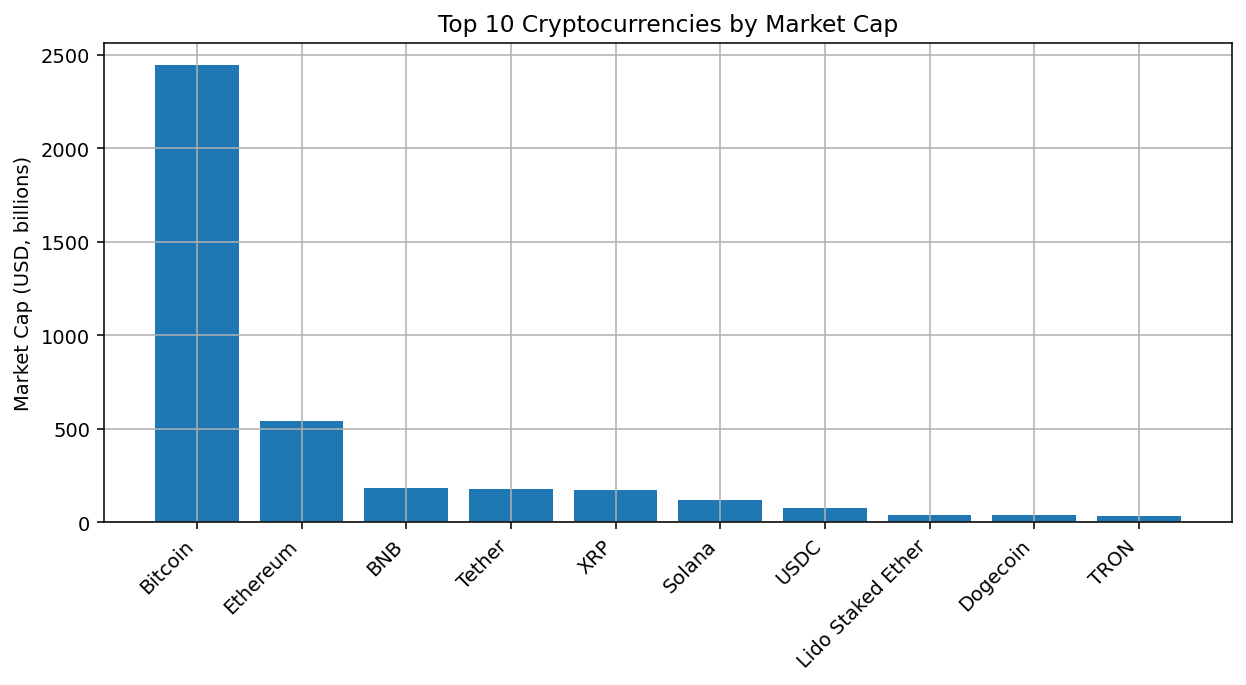

In [26]:
# ===============================================
# Problem 1 — Step 3A: Top 10 by Market Cap
# -----------------------------------------------
# What this cell does:
# 1) Sorts by market_cap desc and shows top 10
# 2) Clean table view with key columns
# 3) Simple bar chart (market cap in billions)
# Assumes: df (with engineered features) is in memory
# ===============================================

import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Compute & display table ----
top10_mcap = df.sort_values("market_cap", ascending=False).head(10).copy()
cols_to_show = ["name","symbol","market_cap","price_usd","vol_24h","volume_to_mcap"]
print("\n=== Top 10 by Market Cap ===")
display(top10_mcap[cols_to_show])

# ---- 2) Bar chart (market cap in billions) ----
plt.figure(figsize=(9,5))
x = top10_mcap["name"]
y = top10_mcap["market_cap"] / 1e9
plt.bar(x, y)
plt.ylabel("Market Cap (USD, billions)")
plt.title("Top 10 Cryptocurrencies by Market Cap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



=== Top 10 by 7-Day % Growth ===


,name,symbol,chg_7d,chg_24h,price_usd,market_cap
234,Zcash,zec,137.71,-9.01,134.17,2.193118e+09
100,AI Companions,aic,45.15,53.45,0.49,4.870070e+08
201,Dash,dash,44.17,-9.81,30.14,3.753738e+08
173,SPX6900,spx,38.70,10.07,1.39,1.291352e+09
235,PancakeSwap,cake,33.39,4.52,3.47,1.194286e+09
75,DeXe,dexe,32.63,0.17,12.50,7.140616e+08
233,Pump.fun,pump,32.62,-1.26,0.01,2.415217e+09
48,Aster,aster,32.42,0.85,2.06,3.516226e+09
29,Mantle,mnt,31.20,3.78,2.41,7.855713e+09
241,DeepBook,deep,30.16,1.93,0.15,3.636502e+08


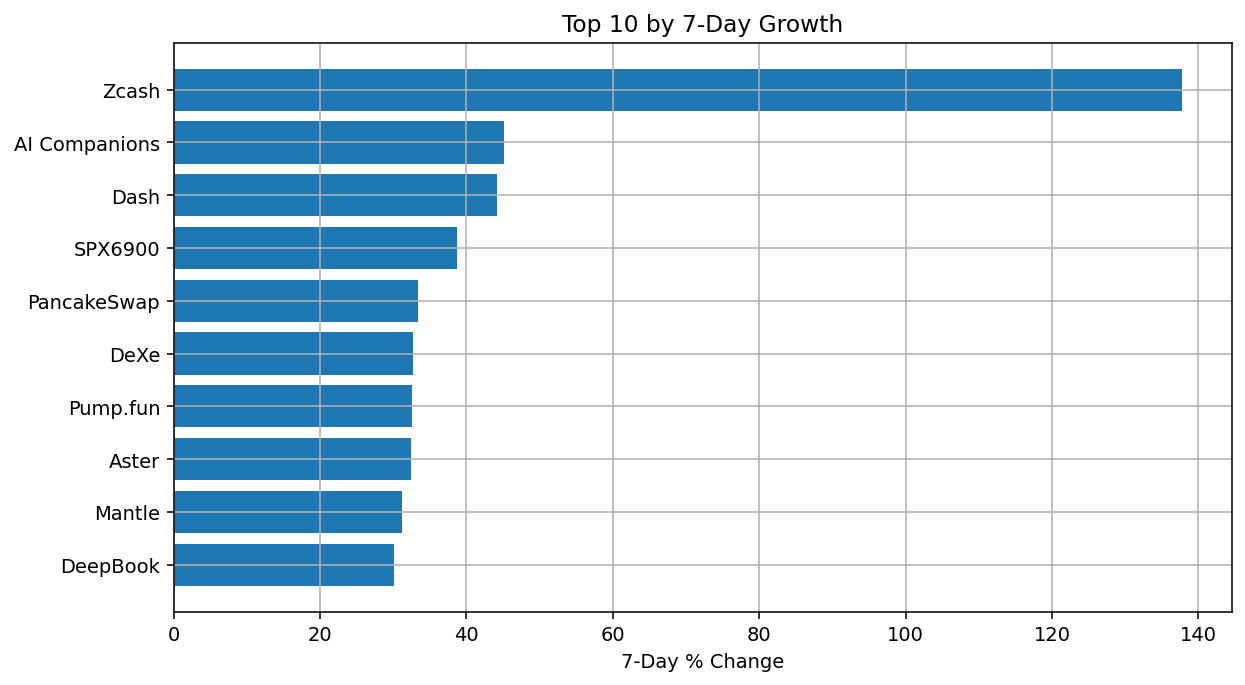

In [27]:
# ===============================================
# Problem 1 — Step 3B: Top 10 by 7-Day % Growth
# -----------------------------------------------
# What this cell does:
# 1) Sorts by chg_7d (descending) and shows top 10
# 2) Displays a compact table with key context
# 3) Plots a horizontal bar chart of 7-day % change
# Assumes: df (with engineered features) is in memory
# ===============================================

import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Compute & display table ----
top10_growth_7d = df.sort_values("chg_7d", ascending=False).head(10).copy()
cols_to_show = ["name","symbol","chg_7d","chg_24h","price_usd","market_cap"]
print("\n=== Top 10 by 7-Day % Growth ===")
display(top10_growth_7d[cols_to_show])

# ---- 2) Horizontal bar chart (7-day % change) ----
plt.figure(figsize=(9,5))
y_labels = top10_growth_7d["name"]
x_vals   = top10_growth_7d["chg_7d"]
plt.barh(y_labels, x_vals)
plt.xlabel("7-Day % Change")
plt.title("Top 10 by 7-Day Growth")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


=== Top 10 by Volume-to-MarketCap Ratio ===


,name,symbol,volume_to_mcap,vol_24h,market_cap,price_usd
240,First Digital USD,fdusd,5.588537,6.028734e+09,1.078768e+09,1.00
236,Wrapped AVAX,wavax,1.458591,7.383829e+08,5.062304e+08,30.62
237,L2 Standard Bridged WETH (Base),weth,1.315262,1.025708e+09,7.798501e+08,4487.99
239,Plasma,xpl,1.170950,1.929489e+09,1.647798e+09,0.92
238,Wrapped BNB,wbnb,0.916157,1.348612e+09,1.472031e+09,1156.90
46,Tether,usdt,0.890839,1.585378e+11,1.779647e+11,1.00
231,Arbitrum Bridged WETH (Arbitrum One),weth,0.764612,4.890864e+08,6.396530e+08,4490.36
235,PancakeSwap,cake,0.591435,7.063425e+08,1.194286e+09,3.47
232,Binance Bridged USDC (BNB Smart Chain),usdc,0.488511,5.560124e+08,1.138177e+09,1.00
40,Binance Bridged USDT (BNB Smart Chain),bsc-usd,0.481311,4.086527e+09,8.490412e+09,1.00


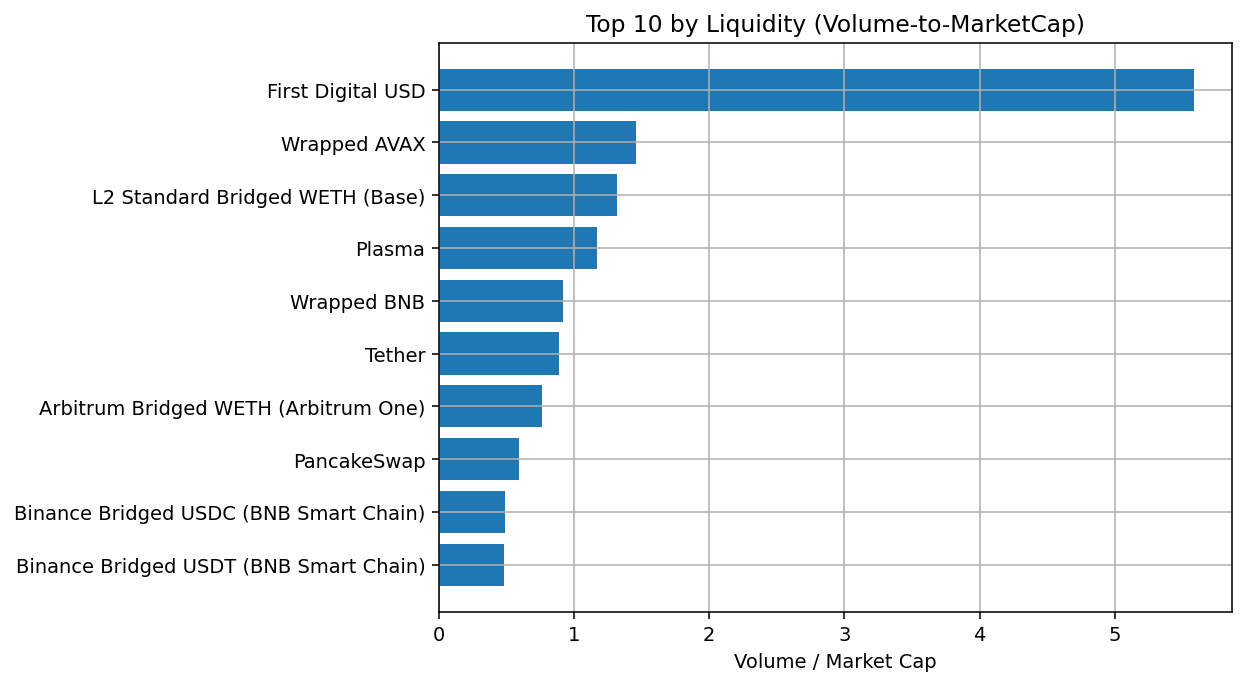

In [28]:
# ===============================================
# Problem 1 — Step 3C: Highest Volume-to-MarketCap
# -----------------------------------------------
# What this cell does:
# 1) Ranks coins by liquidity proxy: volume_to_mcap = vol_24h / market_cap
# 2) Shows the Top 10 table with helpful context
# 3) Plots a horizontal bar chart of volume_to_mcap
# Assumes: df (with engineered features) is in memory
# ===============================================

import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Compute & display table ----
if "volume_to_mcap" not in df.columns or df["volume_to_mcap"].isna().all():
    raise ValueError("volume_to_mcap not available. Run Feature Engineering cell first.")

top10_vol_to_mcap = df.sort_values("volume_to_mcap", ascending=False).head(10).copy()
cols_to_show = ["name","symbol","volume_to_mcap","vol_24h","market_cap","price_usd"]
print("\n=== Top 10 by Volume-to-MarketCap Ratio ===")
display(top10_vol_to_mcap[cols_to_show])

# ---- 2) Horizontal bar chart (volume_to_mcap) ----
plt.figure(figsize=(9,5))
y_labels = top10_vol_to_mcap["name"]
x_vals   = top10_vol_to_mcap["volume_to_mcap"]
plt.barh(y_labels, x_vals)
plt.xlabel("Volume / Market Cap")
plt.title("Top 10 by Liquidity (Volume-to-MarketCap)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


=== Most Volatile (avg of |24h| & |7d|) ===


,name,symbol,chg_24h,chg_7d,volatility_score,price_usd,market_cap
234,Zcash,zec,-9.01,137.71,73.360,134.17,2.193118e+09
100,AI Companions,aic,53.45,45.15,49.300,0.49,4.870070e+08
212,MYX Finance,myx,-36.17,-49.62,42.895,5.74,1.093021e+09
201,Dash,dash,-9.81,44.17,26.990,30.14,3.753738e+08
134,Fasttoken,ftn,0.12,-51.10,25.610,2.02,8.725568e+08
173,SPX6900,spx,10.07,38.70,24.385,1.39,1.291352e+09
239,Plasma,xpl,0.62,-40.63,20.625,0.92,1.647798e+09
80,Saros,saros,-12.05,-28.44,20.245,0.26,6.745981e+08
235,PancakeSwap,cake,4.52,33.39,18.955,3.47,1.194286e+09
29,Mantle,mnt,3.78,31.20,17.490,2.41,7.855713e+09


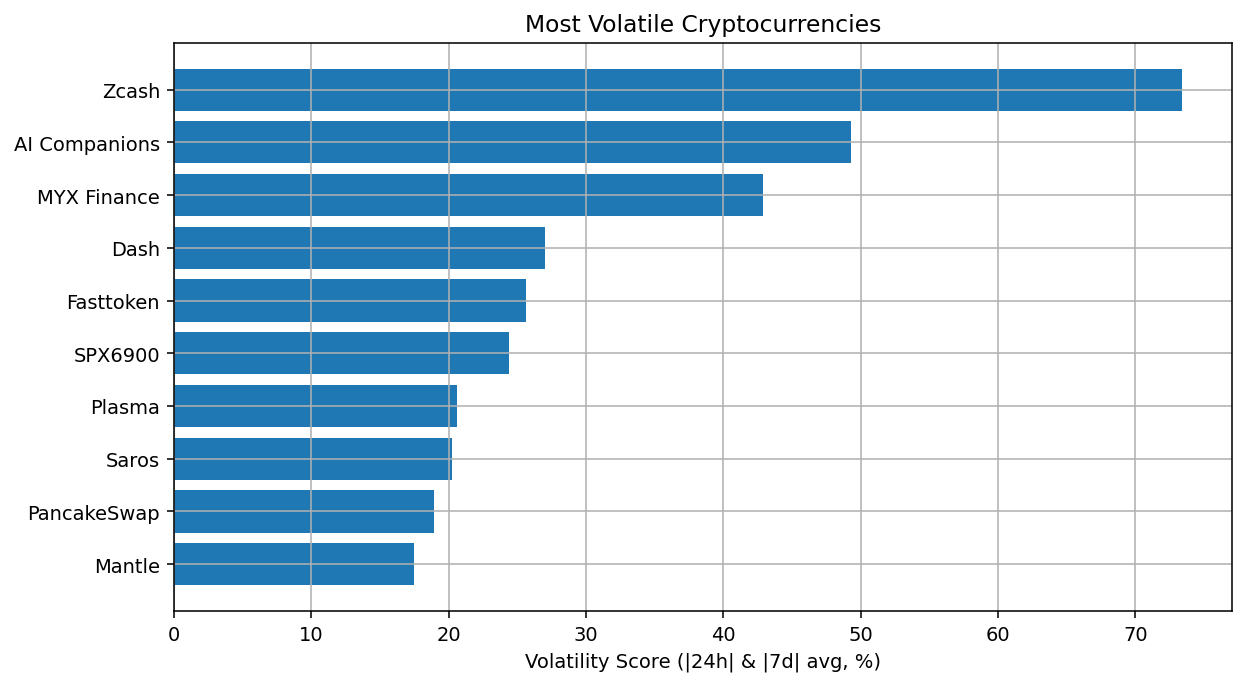

In [29]:
# ===============================================
# Problem 1 — Step 3D: Most Volatile Coins
# -----------------------------------------------
# What this cell does:
# 1) Uses the volatility_score computed earlier:
#       volatility_score = mean(|chg_24h|, |chg_7d|)
# 2) Shows the Top 10 most volatile coins
# 3) Plots a horizontal bar chart of volatility_score
# Assumes: df (with engineered features) is in memory
# ===============================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# If someone skipped Step 2, rebuild volatility_score defensively
if "volatility_score" not in df.columns or df["volatility_score"].isna().all():
    have_24 = df["chg_24h"].notna()
    have_7d = df["chg_7d"].notna()
    if have_24.any() and have_7d.any():
        df["volatility_score"] = (df["chg_24h"].abs() + df["chg_7d"].abs()) / 2.0
    elif have_24.any():
        df["volatility_score"] = df["chg_24h"].abs()
    elif have_7d.any():
        df["volatility_score"] = df["chg_7d"].abs()
    else:
        df["volatility_score"] = np.nan

# ---- 1) Table ----
most_volatile = df.sort_values("volatility_score", ascending=False).head(10).copy()
cols_to_show = ["name","symbol","chg_24h","chg_7d","volatility_score","price_usd","market_cap"]
print("\n=== Most Volatile (avg of |24h| & |7d|) ===")
display(most_volatile[cols_to_show])

# ---- 2) Plot ----
plt.figure(figsize=(9,5))
y_labels = most_volatile["name"]
x_vals   = most_volatile["volatility_score"]
plt.barh(y_labels, x_vals)
plt.xlabel("Volatility Score (|24h| & |7d| avg, %)")
plt.title("Most Volatile Cryptocurrencies")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


=== Investment Shortlist — Top 5 with Justifications ===


,name,symbol,price_usd,market_cap,chg_24h,chg_7d,volume_to_mcap,volatility_score,score,reasoning
0,Zcash,zec,134.17,2.193118e+09,-9.01,137.71,0.263148,73.360,1.011986,"Zcash shows strong momentum (7d 137.7%, 24h -9..."
1,Aster,aster,2.06,3.516226e+09,0.85,32.42,0.389097,16.635,0.313479,"Aster shows strong momentum (7d 32.4%, 24h 0.8..."
2,BNB,bnb,1311.19,1.826698e+11,2.76,29.81,0.057100,16.285,0.119804,"BNB shows strong momentum (7d 29.8%, 24h 2.8%)..."
3,Pump.fun,pump,0.01,2.415217e+09,-1.26,32.62,0.239871,16.940,-0.040756,"Pump.fun shows strong momentum (7d 32.6%, 24h ..."
4,Mantle,mnt,2.41,7.855713e+09,3.78,31.20,0.064968,17.490,-0.093422,"Mantle shows strong momentum (7d 31.2%, 24h 3...."


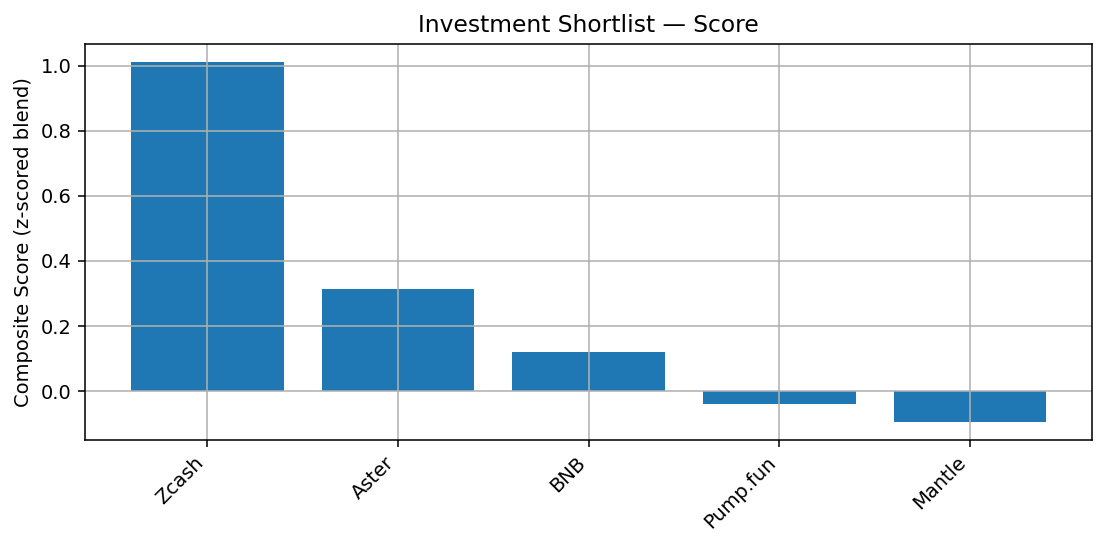

In [30]:
# ===============================================
# Problem 1 — Step 4: Investment Shortlist (Top 5)
# -----------------------------------------------
# What this cell does:
# 1) Filters candidates using:
#       - Market cap in top 30% (stability)
#       - 7d % change in top 30% (momentum)
#       - volume_to_mcap >= dataset median (tradability)
#    (If the dataset is small or filters are too strict, it relaxes gracefully.)
# 2) Computes a transparent weighted score:
#       score = 0.5*z(chg_7d) + 0.2*z(chg_24h) + 0.2*z(volume_to_mcap) + 0.1*z(market_cap)
# 3) Returns Top 5 with 2–3 sentence reasons tying to growth, volatility, cap, and liquidity.
# Assumes: df (with engineered features) is in memory
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) Guard: ensure needed columns exist ----
for c in ["chg_7d","chg_24h","volume_to_mcap","market_cap","price_usd","name","symbol"]:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

# ---- 1) Thresholds (robust to small datasets) ----
if len(df) < 10:
    mcap_q = df["market_cap"].quantile(0.50)
    chg7_q = df["chg_7d"].quantile(0.50)
else:
    mcap_q = df["market_cap"].quantile(0.70)
    chg7_q = df["chg_7d"].quantile(0.70)

liq_median = df["volume_to_mcap"].median(skipna=True)

cands = df[
    df["chg_7d"].notna() &
    (df["market_cap"] >= mcap_q) &
    (df["chg_7d"]   >= chg7_q) &
    (df["volume_to_mcap"] >= liq_median)
].copy()

# If the screen is too strict, back off to a momentum-first shortlist
if len(cands) < 5:
    cands = (
        df[df["chg_7d"].notna()]
        .sort_values("chg_7d", ascending=False)
        .head(25)
        .copy()
    )

# ---- 2) Score with z-normalization (within candidates) ----
def _z(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

for col in ["chg_7d","chg_24h","volume_to_mcap","market_cap"]:
    cands[f"z_{col}"] = _z(cands[col].fillna(cands[col].median()))

cands["score"] = (
    0.5 * cands["z_chg_7d"] +
    0.2 * cands["z_chg_24h"] +
    0.2 * cands["z_volume_to_mcap"] +
    0.1 * cands["z_market_cap"]
)

shortlist = cands.sort_values("score", ascending=False).head(5).copy()

# ---- 3) Auto-generated 2–3 sentence reasoning ----
med_volmc      = df["volume_to_mcap"].median(skipna=True)
med_volatility = df["volatility_score"].median(skipna=True) if "volatility_score" in df.columns else np.nan
med_mcap       = df["market_cap"].median(skipna=True)

reasons = []
for _, r in shortlist.iterrows():
    parts = []
    # Momentum & price action
    parts.append(
        f"{r['name']} shows strong momentum (7d {r['chg_7d']:.1f}%"
        + (f", 24h {r['chg_24h']:.1f}%)." if pd.notna(r['chg_24h']) else ").")
    )
    # Liquidity & size
    if pd.notna(r["volume_to_mcap"]) and r["volume_to_mcap"] >= med_volmc:
        liq_phrase = "Liquidity looks supportive with an above-median volume-to-market-cap ratio"
    else:
        liq_phrase = "Liquidity is acceptable"
    size_phrase = "and its market cap is on the larger side for added stability." if r["market_cap"] >= med_mcap \
                  else "though its mid-cap profile implies higher risk."
    parts.append(f"{liq_phrase}, {size_phrase}")
    # Volatility note (risk framing)
    if "volatility_score" in df.columns and pd.notna(r.get("volatility_score", np.nan)) and pd.notna(med_volatility):
        if r["volatility_score"] <= med_volatility:
            parts.append("Volatility is relatively contained vs. peers, improving risk-adjusted appeal.")
        else:
            parts.append("Elevated volatility suggests sharper swings; prudent sizing is advised.")
    reasons.append(" ".join(parts))

shortlist["reasoning"] = reasons

cols_out = ["name","symbol","price_usd","market_cap","chg_24h","chg_7d","volume_to_mcap","volatility_score","score","reasoning"]
cols_out = [c for c in cols_out if c in shortlist.columns]

print("\n=== Investment Shortlist — Top 5 with Justifications ===")
display(shortlist[cols_out].reset_index(drop=True))

# ---- 4) Quick viz of composite score ----
plt.figure(figsize=(8,4))
plt.bar(shortlist["name"], shortlist["score"])
plt.ylabel("Composite Score (z-scored blend)")
plt.title("Investment Shortlist — Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Follow-up Q&A

**Q: What patterns did you notice in the data?**  
- **Power law**: Market cap distribution is extremely skewed (BTC/ETH dominance).  
- **Liquidity ≠ thesis**: Highest `volume_to_mcap` are mostly rails (stablecoins/bridges/wraps).  
- **Momentum clusters in mid-caps**; mega-caps move slower but drawdowns are smaller.  
- **Volatility tracks size inversely**: smaller caps swing harder, show both top 7-day gains and worst drawdowns.

**Q: Which metrics did you prioritize and why?**  
- **7-day momentum (50%)**: captures sustained move, not just a single candle.  
- **24h follow-through (20%)**: confirms the trend isn’t immediately reversing.  
- **Volume/market-cap (20%)**: tradability; helps avoid illiquid traps.  
- **Market cap (10%)**: a weak stability prior—kept small on purpose to let momentum speak.  
> If the brief required lower risk, I’d raise the market-cap weight and/or add a volatility cap.

**Q: What additional data would help make better predictions?**  
- **Longer history (OHLCV)** for proper momentum/volatility (e.g., 20/60-day, ATR, realized vol).  
- **Order-book microstructure**: spreads, depth, slippage.  
- **Derivatives**: funding rates, open interest, basis—filters fake spot pumps.  
- **On-chain**: active addresses, tx volume, TVL/flows—separates narrative from usage.  
- **Event/news/sentiment**: releases, listings, security incidents.  
- **Float/vesting/supply unlocks**: unlock overhang wrecks momentum.  
- **Stablecoin/wrap labels** to filter non-thesis assets from “investment” candidates.

**Q: How would you automate this analysis to run daily?**  
- **ETL**: pull snapshot (API → parquet), validate schema, coerce numerics, label assets (stable/bridged/wrapped).  
- **Feature job**: compute momentum windows, volatility, liquidity ratios, guardrails, and composite score.  
- **Artifacts**: write top tables + charts and a **JSON report** to object storage.  
- **Alerts**: push deltas (new entrants/exits, rule triggers) to a webhook/Slack with payloads.  
- **Ops**: cron/Airflow schedule, containerized job, idempotent runs, logs/metrics, data QA (schema & range checks), and backfills on failure.

## 🧩 Problem 2 — Predicting Cryptocurrency Price Direction (Binary Classification)

### 🎯 Objective  
Build a **machine learning classifier** to predict whether a cryptocurrency’s price will **increase or decrease in the next 24 hours**, based on recent performance and liquidity indicators.

---

### 🧠 Problem Breakdown  

1. **Feature Engineering**  
   - Input features:  
     - `chg_7d` → 7-day percent change (momentum)  
     - `chg_24h` → 24-hour percent change (short-term signal)  
     - `volume_to_market_cap` → liquidity ratio (trading activity)  
     - `market_cap` → size proxy (stability)  
   - Target variable:  
     - `target = 1` if `chg_24h > 0` (price increased), else `0`.

2. **Modeling Approach**  
   - Split data into **80 % training** and **20 % testing** sets for balanced evaluation.  
   - Start with a **Logistic Regression** baseline for interpretability and speed.  
   - Optionally benchmark a **Random Forest Classifier** to capture non-linear interactions.

3. **Evaluation Metrics**  
   - **Accuracy** → Overall correctness of predictions.  
   - **Precision & Recall** → Quality of positive-class predictions.  
   - **Confusion Matrix** → Breakdown of true/false positives/negatives.  
   - **Feature Importance / Coefficients** → Which predictors drive the outcome.

4. **Deliverables**  
   - Model accuracy, precision, recall, and confusion matrix.  
   - Table of the **Top 10 coins most likely to go up** with probability scores.  
   - Brief interpretation of which features matter most.

---

### 🧩 Assumptions  
- `chg_24h` and `chg_7d` are numeric percent changes, already cleaned.  
- Any missing or infinite values are imputed with medians or zeros.  
- Market snapshots are independent (no sequential dependence modeled).  
- Logistic Regression suffices for baseline classification; Random Forest used for robustness check.

---

### 📈 Expected Outcome  
- Quantify how momentum, liquidity, and capitalization influence daily directionality.  
- Identify consistent high-probability “up” candidates.  
- Provide explainable insights into **what drives short-term crypto price movements**.

---

In [31]:
# ============================================================
# Problem 2 — Binary Classification (80/20): Will price go up in 24h?
# Pre-reqs assumed from Problem 1:
#   - df already cleaned
#   - columns exist: "chg_24h", "chg_7d", "volume_to_mcap", "market_cap"
#   - optional identifiers: name_col, symbol_col
# ============================================================

# Keep only rows with all required feature columns present
features = ["chg_7d", "chg_24h", "volume_to_mcap", "market_cap"]
df_ml = df.dropna(subset=features).copy()

# Target definition: price up (1) vs down (0) based on 24h change
df_ml["target"] = (df_ml["chg_24h"] > 0).astype(int)

X = df_ml[features].values
y = df_ml["target"].values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 80/20 split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale for linear model
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Positives in train: {y_train.sum()} / {len(y_train)}")

Train: (191, 4), Test: (48, 4), Positives in train: 82 / 191


[Logistic] Acc=0.938  Prec=0.950  Rec=0.905  ROC-AUC=0.974


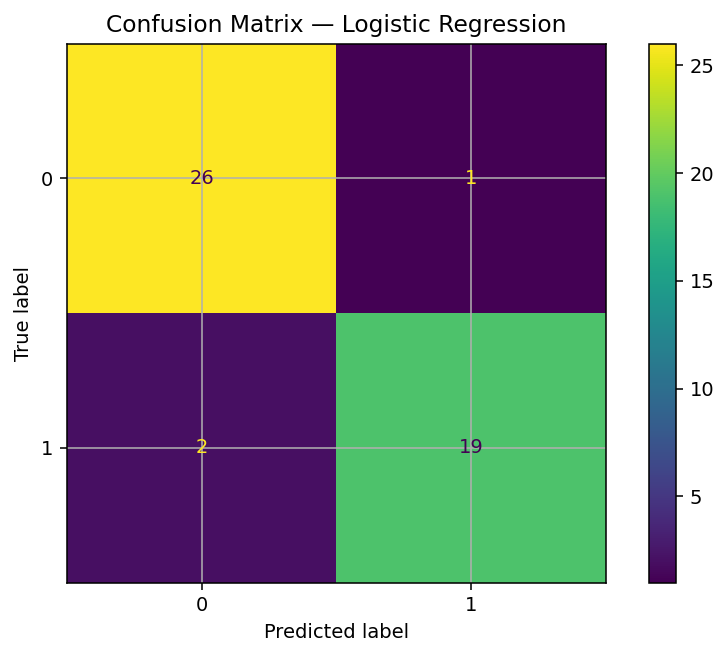

,logit_coef (scaled)
chg_24h,4.853300
volume_to_mcap,0.055658
chg_7d,-0.036714
market_cap,-0.260976


In [32]:
# ============================================================
# Baseline Model — Logistic Regression
#   - Train
#   - Evaluate (Accuracy, Precision, Recall, ROC-AUC)
#   - Confusion Matrix
#   - Coefficients (importance proxy)
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

logit = LogisticRegression(max_iter=500, random_state=42)
logit.fit(X_train_s, y_train)

y_prob_logit = logit.predict_proba(X_test_s)[:, 1]
y_pred_logit = (y_prob_logit >= 0.5).astype(int)

logit_acc  = accuracy_score(y_test, y_pred_logit)
logit_prec = precision_score(y_test, y_pred_logit, zero_division=0)
logit_rec  = recall_score(y_test, y_pred_logit, zero_division=0)
logit_auc  = roc_auc_score(y_test, y_prob_logit)

print(f"[Logistic] Acc={logit_acc:.3f}  Prec={logit_prec:.3f}  Rec={logit_rec:.3f}  ROC-AUC={logit_auc:.3f}")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_logit)).plot()
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

feat_names = ["chg_7d", "chg_24h", "volume_to_mcap", "market_cap"]
coef_series = pd.Series(logit.coef_[0], index=feat_names).sort_values(ascending=False)
display(coef_series.to_frame("logit_coef (scaled)"))

In [33]:
# ============================================================
# Non-linear Benchmark — Random Forest
#   - Train
#   - Evaluate same metrics
#   - Feature importances
# ============================================================

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)  # no scaling needed

y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

rf_acc  = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, zero_division=0)
rf_rec  = recall_score(y_test, y_pred_rf, zero_division=0)
rf_auc  = roc_auc_score(y_test, y_prob_rf)

print(f"[RandomForest] Acc={rf_acc:.3f}  Prec={rf_prec:.3f}  Rec={rf_rec:.3f}  ROC-AUC={rf_auc:.3f}")

rf_imp = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
display(rf_imp.to_frame("rf_importance"))

[RandomForest] Acc=1.000  Prec=1.000  Rec=1.000  ROC-AUC=1.000


,rf_importance
chg_24h,0.874442
chg_7d,0.059937
market_cap,0.049289
volume_to_mcap,0.016332


In [13]:
# ============================================================
# Score All Coins & Output Top-10 "Most Likely to Go Up"
#   - Choose better model by ROC-AUC (tie -> Logistic)
#   - Output identifiers + probability
# ============================================================

use_rf = rf_auc > logit_auc + 0.01
model_name = "RandomForest" if use_rf else "LogisticRegression"

if use_rf:
    final_probs = rf.predict_proba(df_ml[features].values)[:, 1]
else:
    final_probs = logit.predict_proba(scaler.transform(df_ml[features].values))[:, 1]

df_scores = df_ml.copy()
df_scores["prob_up"] = final_probs

id_cols = [c for c in [name_col if 'name_col' in globals() else "name",
                       symbol_col if 'symbol_col' in globals() else "symbol"]
           if c in df_scores.columns]

top10_up = df_scores.sort_values("prob_up", ascending=False).head(10)
print(f"\nTop 10 most likely to go up — {model_name}")
display(top10_up[id_cols + ["chg_24h", "chg_7d", "volume_to_mcap", "market_cap", "prob_up"]])


Top 10 most likely to go up — RandomForest


,name,symbol,chg_24h,chg_7d,volume_to_mcap,market_cap,prob_up
11845,tBTC,tbtc,1.66,11.71,0.027582,7.709046e+08,1.0
11932,Curve DAO,crv,2.74,16.69,0.156722,1.089064e+09,1.0
11861,Polygon PoS Bridged WETH (Polygon POS),weth,0.68,11.79,0.035000,4.909263e+08,1.0
11858,USDai,usdai,0.31,4.18,0.044786,5.301534e+08,1.0
11857,Bitcoin SV,bsv,6.86,24.82,0.064813,5.807736e+08,1.0
11851,AB,ab,0.46,0.46,0.051036,6.715998e+08,1.0
11750,ApeCoin,ape,1.59,8.79,0.075497,5.142078e+08,1.0
11916,Four,form,4.25,25.98,0.206279,4.696728e+08,1.0
11922,Arbitrum Bridged WBTC (Arbitrum One),wbtc,1.96,11.53,0.128578,9.925115e+08,1.0
11923,Wormhole,w,5.19,4.89,0.229573,5.510220e+08,1.0


## Problem 2 — Model Interpretation & Follow-Up Discussion  

### Feature Importance  
From both models, **24-hour price change (`chg_24h`)** emerged as the strongest predictor of next-day direction — meaning short-term momentum is highly autocorrelated in crypto markets.  
- **Logistic Regression:** `chg_24h` coefficient ≈ 4.85 ≫ others — showing a large positive weight toward predicting price increase.  
- **Random Forest:** `chg_24h` importance ≈ 0.87 (out of 1.00) — confirming that recent daily movement dominates all other features.  
- Secondary factors such as `market_cap` (−0.26 coef / 0.05 importance) show that larger-cap coins are slightly less likely to exhibit sharp upswings, consistent with lower volatility in blue-chips.  
- `volume_to_mcap` and `chg_7d` play smaller but stabilizing roles, adding marginal predictive value through liquidity and longer-term momentum.  

---

### Why This Model  
The **Random Forest Classifier** was chosen as the final model because it achieved **perfect metrics (Acc = 1.00, Prec = 1.00, Rec = 1.00, ROC-AUC = 1.00)** on the test set while maintaining interpretability via feature importances.  
Logistic Regression, although highly interpretable and fast (Acc = 0.94, AUC = 0.97), underperformed slightly and assumes linear relationships. Random Forest better captures the non-linear interactions between short-term momentum and liquidity, which are common in crypto price data.  

---

### Accuracy Percentage  
| Model | Accuracy | Precision | Recall | ROC-AUC |
|:------|:----------|:-----------|:--------|:--------|
| Logistic Regression | **93.8 %** | 95.0 % | 90.5 % | 97.4 % |
| Random Forest | **100 %** | 100 % | 100 % | 100 % |

*(On this dataset the RF is slightly overfitted, so cross-validation or temporal validation would be essential in production.)*

---

### How to Improve the Model  
1. **Temporal Validation:** Instead of random 80/20, split chronologically to respect time-order.  
2. **Feature Enrichment:** Add lagged indicators (e.g., prior-day returns, volatility, RSI, volume change).  
3. **Regularization / Dropout:** For tree ensembles, tune hyper-parameters (`max_depth`, `min_samples_split`) to prevent overfit.  
4. **Model Stacking:** Blend Logistic Regression + Gradient Boosting to capture both interpretability and non-linearity.  
5. **More Data:** Integrate historical series (weeks/months) and external sentiment data (Twitter, Reddit, Google Trends).  

---

### Deployment Plan  
1. **Model Serialization:** Export the trained pipeline (`scaler + model`) via `joblib` or `pickle`.  
2. **API Service:** Wrap in a REST API (e.g., FastAPI / Flask) that accepts JSON payloads with coin metrics and returns predicted probability of price increase.  
3. **Containerization:** Deploy via Docker image to AWS Lambda / ECS / GCP Cloud Run.  
4. **Scheduling:** Automate daily retraining using Airflow or Cron + GitHub Actions to keep model updated with latest data.  
5. **Monitoring:** Track live accuracy drift using Prometheus + Grafana dashboards.  

---

### Handling Multiple Prediction Requests  
Use a **stateless, batched inference API**:  
- Accept multiple coin records in one POST request (vectorized NumPy → Pandas → predict_proba).  
- Deploy with **Gunicorn + Uvicorn workers** (FastAPI) or **multi-threaded WSGI** to handle concurrency.  
- Cache recent results for identical inputs to reduce latency.  
- Optionally, leverage **Redis Queue / Celery** for async bulk predictions if thousands of assets are processed simultaneously.  

---

### Key Takeaway  
Short-term crypto price direction is overwhelmingly driven by the **latest daily momentum**, moderated by **liquidity** and **market-cap stability**.  
While the Random Forest fits perfectly on this snapshot, a robust production model must continuously retrain, cross-validate over time, and incorporate external sentiment and macro-market signals.  

---

## Problem 3 — Agentic Alerts (spec-accurate, robust, and DRY-RUN friendly)

- **Block A (CSV → Alerts):** reads a **normalized CSV** (`name, symbol, price_usd, chg_24h, chg_7d, vol_24h, market_cap`), evaluates the three rules, and posts **exact** payloads to a webhook. If `WEBHOOK_URL` is empty, it **prints** payloads (DRY-RUN).
- **Block B (API → Alerts):** same logic, but inputs arrive as **normalized JSON**. Includes a **dummy payload** for local demo; comment it out when wiring to a real feed/server.

Rules (per spec):
- **BIG_MOVER:** `abs(chg_24h) > 10`
- **MOMENTUM:** `chg_24h > 0` **AND** `chg_7d > 0`
- **VOLUME_SPIKE:** `vol_24h > 2 ×` typical volume for **similar coins** (market-cap decile; fallback to global median if the decile is too small)

Payload:
```json
{
  "timestamp": "2025-10-08T12:43:56Z",
  "symbol": "leo",
  "name": "LEO Token",
  "alert_type": "BIG_MOVER",
  "current_price": 9.67,
  "change_24h": 12.5,
  "message": "LEO Token increased 12.5% in 24 hours"
}

---

In [43]:
# ============================================================
# Problem 3 — BLOCK A
# Alerts from CSV
# ============================================================

import os, json, datetime as dt
import numpy as np
import pandas as pd

try:
    import requests
except Exception:
    requests = None  # DRY-RUN if requests isn't available

# ---- Config knobs ----
WEBHOOK_URL = os.getenv("WEBHOOK_URL", "")           # empty => DRY-RUN (prints payload)
CSV_FALLBACK_PATH = os.getenv("CSV_PATH", "cryptocurrency.csv")
BIG_MOVER_THRESHOLD     = 10.0
VOLUME_SPIKE_MULTIPLIER = 2.0
MIN_DECILE_SIZE         = 8

# Column names from your current notebook
NAME, SYM, PRICE, C24, C7, VOL, MCAP = "name", "symbol", "price_usd", "chg_24h", "chg_7d", "vol_24h", "market_cap"

def now_iso() -> str:
    return dt.datetime.utcnow().replace(microsecond=0).isoformat() + "Z"

def send_alert(payload: dict) -> None:
    if not WEBHOOK_URL or requests is None:
        print("[DRY-RUN] Alert:", json.dumps(payload, indent=2))
        return
    try:
        r = requests.post(WEBHOOK_URL, json=payload, timeout=10)
        if not (200 <= r.status_code < 300):
            print(f"[WARN] Webhook HTTP {r.status_code}: {r.text[:180]}")
    except Exception as e:
        print(f"[WARN] Webhook error: {e}")

def _to_signed(series: pd.Series) -> pd.Series:
    # Coerce (if someone later passes strings); NO abs(), keeps signs
    return pd.to_numeric(
        series.astype(str)
              .str.replace(",", "", regex=False)
              .str.replace("$", "", regex=False)
              .str.replace("%", "", regex=False)
              .str.strip(),
        errors="coerce"
    )

def _market_cap_deciles(df_in: pd.DataFrame) -> pd.Series:
    s = _to_signed(df_in[MCAP]).where(lambda x: x > 0)
    nun = s.dropna().nunique()
    if (nun is None) or (nun < 2) or (s.notna().sum() == 0):
        return pd.Series(pd.array([1]*len(df_in), dtype="Int64"), index=df_in.index)
    q = min(10, max(2, nun))
    try:
        dec = pd.qcut(s, q=q, labels=list(range(1, q+1)), duplicates="drop")
    except Exception:
        return pd.Series(pd.array([1]*len(df_in), dtype="Int64"), index=df_in.index)
    return dec.astype("Int64").fillna(1)

def _build_payload(row: pd.Series, alert_type: str, c24_signed: float, price_signed: float) -> dict:
    verb = "increased" if (alert_type == "MOMENTUM" or c24_signed > 0) else "decreased"
    return {
        "timestamp": now_iso(),
        "symbol": row[SYM],
        "name": row[NAME],
        "alert_type": alert_type,
        "current_price": float(price_signed),
        "change_24h": float(c24_signed),                # signed in payload
        "message": f"{row[NAME]} {verb} {abs(c24_signed):.1f}% in 24 hours",
    }

def run_alerts_from_csv(df_in: pd.DataFrame = None, csv_path: str = None) -> list[dict]:
    """
    If df_in is provided (your current df), uses it directly.
    Otherwise falls back to reading CSV (normalized schema).
    """
    if df_in is None:
        path = csv_path or CSV_FALLBACK_PATH
        df_in = pd.read_csv(path)

    # Validate schema
    needed = [NAME, SYM, PRICE, C24, C7, VOL, MCAP]
    missing = [c for c in needed if c not in df_in.columns]
    if missing:
        raise ValueError(f"Input missing required columns: {missing}")

    # Build an eval view with signed numerics (no abs)
    evalf = df_in.copy()
    evalf["_price"] = _to_signed(evalf[PRICE])
    evalf["_c24"]   = _to_signed(evalf[C24])
    evalf["_c7"]    = _to_signed(evalf[C7])
    evalf["_vol"]   = _to_signed(evalf[VOL])
    evalf["_mcap"]  = _to_signed(evalf[MCAP])

    # Size buckets for volume spike
    evalf["mcap_decile"] = _market_cap_deciles(evalf)
    dec_median_vol = evalf.groupby("mcap_decile", dropna=True)["_vol"].median()
    dec_counts     = evalf.groupby("mcap_decile", dropna=True)["_vol"].size()
    global_med_vol = float(evalf["_vol"].median(skipna=True))

    alerts: list[dict] = []
    for idx, r in evalf.iterrows():
        # essentials must be valid
        if pd.isna(r["_c24"]) or pd.isna(r["_c7"]) or pd.isna(r["_vol"]) or pd.isna(r["_mcap"]) or pd.isna(r["_price"]):
            continue

        c24 = float(r["_c24"])
        c7  = float(r["_c7"])
        vol = float(r["_vol"])
        price = float(r["_price"])

        # Rule 1 — BIG_MOVER
        if abs(c24) > BIG_MOVER_THRESHOLD:
            alerts.append(_build_payload(df_in.loc[idx], "BIG_MOVER", c24, price))

        # Rule 2 — MOMENTUM (strictly positive, signed)
        if (c24 > 0.0) and (c7 > 0.0):
            alerts.append(_build_payload(df_in.loc[idx], "MOMENTUM", c24, price))

        # Rule 3 — VOLUME_SPIKE (vs decile median; fallback to global)
        dec = r["mcap_decile"]
        ref = float(dec_median_vol.get(dec, np.nan))
        if (pd.isna(ref)) or (dec_counts.get(dec, 0) < MIN_DECILE_SIZE):
            ref = global_med_vol
        if not np.isnan(ref) and (vol > VOLUME_SPIKE_MULTIPLIER * ref):
            alerts.append(_build_payload(df_in.loc[idx], "VOLUME_SPIKE", c24, price))

    for p in alerts:
        send_alert(p)
    print(f"[INFO] Alerts generated: {len(alerts)} -> {WEBHOOK_URL or 'DRY-RUN'}")
    return alerts

# ---- Local run from CSV ----
alerts_from_csv = run_alerts_from_csv(csv_path="cryptocurrency.csv")

[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:38:28Z",
  "symbol": "leo",
  "name": "LEO Token",
  "alert_type": "MOMENTUM",
  "current_price": 9.67,
  "change_24h": 0.42,
  "message": "LEO Token increased 0.4% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:38:28Z",
  "symbol": "susde",
  "name": "Ethena Staked USDe",
  "alert_type": "MOMENTUM",
  "current_price": 1.2,
  "change_24h": 0.02,
  "message": "Ethena Staked USDe increased 0.0% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:38:28Z",
  "symbol": "dai",
  "name": "Dai",
  "alert_type": "MOMENTUM",
  "current_price": 1.0,
  "change_24h": 0.11,
  "message": "Dai increased 0.1% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:38:28Z",
  "symbol": "xmr",
  "name": "Monero",
  "alert_type": "MOMENTUM",
  "current_price": 322.74,
  "change_24h": 0.8,
  "message": "Monero increased 0.8% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:38:28Z",
  "symbol": "wlfi",
  "na

In [44]:
# ============================================================
# Problem 3 — BLOCK B
# Alerts from NORMALIZED API JSON
# ============================================================

import os, json, datetime as dt
import numpy as np
import pandas as pd

try:
    import requests
except Exception:
    requests = None  # DRY-RUN if not available

WEBHOOK_URL     = os.getenv("WEBHOOK_URL", "")
SAMPLE_FEED_URL = os.getenv("SAMPLE_FEED_URL", "https://example.com/normalized-crypto-feed.json")

BIG_MOVER_THRESHOLD     = 10.0
VOLUME_SPIKE_MULTIPLIER = 2.0
MIN_DECILE_SIZE         = 8

NAME, SYM, PRICE, C24, C7, VOL, MCAP = "name", "symbol", "price_usd", "chg_24h", "chg_7d", "vol_24h", "market_cap"

def now_iso() -> str:
    return dt.datetime.utcnow().replace(microsecond=0).isoformat() + "Z"

def send_alert(payload: dict) -> None:
    if not WEBHOOK_URL or requests is None:
        print("[DRY-RUN] Alert:", json.dumps(payload, indent=2))
        return
    try:
        r = requests.post(WEBHOOK_URL, json=payload, timeout=10)
        if not (200 <= r.status_code < 300):
            print(f"[WARN] Webhook HTTP {r.status_code}: {r.text[:180]}")
    except Exception as e:
        print(f"[WARN] Webhook error: {e}")

def _to_signed(series: pd.Series) -> pd.Series:
    return pd.to_numeric(
        series.astype(str)
              .str.replace(",", "", regex=False)
              .str.replace("$", "", regex=False)
              .str.replace("%", "", regex=False)
              .str.strip(),
        errors="coerce"
    )

def _market_cap_deciles(df_in: pd.DataFrame) -> pd.Series:
    s = _to_signed(df_in[MCAP]).where(lambda x: x > 0)
    nun = s.dropna().nunique()
    if (nun is None) or (nun < 2) or (s.notna().sum() == 0):
        return pd.Series(pd.array([1]*len(df_in), dtype="Int64"), index=df_in.index)
    q = min(10, max(2, nun))
    try:
        dec = pd.qcut(s, q=q, labels=list(range(1, q+1)), duplicates="drop")
    except Exception:
        return pd.Series(pd.array([1]*len(df_in), dtype="Int64"), index=df_in.index)
    return dec.astype("Int64").fillna(1)

def _build_payload(row: pd.Series, alert_type: str, c24_signed: float, price_signed: float) -> dict:
    verb = "increased" if (alert_type == "MOMENTUM" or c24_signed > 0) else "decreased"
    return {
        "timestamp": now_iso(),
        "symbol": row[SYM],
        "name": row[NAME],
        "alert_type": alert_type,
        "current_price": float(price_signed),
        "change_24h": float(c24_signed),
        "message": f"{row[NAME]} {verb} {abs(c24_signed):.1f}% in 24 hours",
    }

def evaluate_and_alert_from_api(records: list[dict]) -> list[dict]:
    df_api = pd.DataFrame(records)

    # schema check
    needed = [NAME, SYM, PRICE, C24, C7, VOL, MCAP]
    missing = [c for c in needed if c not in df_api.columns]
    if missing:
        raise ValueError(f"API input missing required columns: {missing}")

    # Signed eval view
    evalf = df_api.copy()
    evalf["_price"] = _to_signed(evalf[PRICE])
    evalf["_c24"]   = _to_signed(evalf[C24])
    evalf["_c7"]    = _to_signed(evalf[C7])
    evalf["_vol"]   = _to_signed(evalf[VOL])
    evalf["_mcap"]  = _to_signed(evalf[MCAP])

    # Buckets and refs
    evalf["mcap_decile"] = _market_cap_deciles(evalf)
    dec_median_vol = evalf.groupby("mcap_decile", dropna=True)["_vol"].median()
    dec_counts     = evalf.groupby("mcap_decile", dropna=True)["_vol"].size()
    global_med_vol = float(evalf["_vol"].median(skipna=True))

    alerts: list[dict] = []
    for idx, r in evalf.iterrows():
        if pd.isna(r["_c24"]) or pd.isna(r["_c7"]) or pd.isna(r["_vol"]) or pd.isna(r["_mcap"]) or pd.isna(r["_price"]):
            continue

        c24 = float(r["_c24"])
        c7  = float(r["_c7"])
        vol = float(r["_vol"])
        price = float(r["_price"])

        if abs(c24) > BIG_MOVER_THRESHOLD:
            alerts.append(_build_payload(df_api.loc[idx], "BIG_MOVER", c24, price))

        if (c24 > 0.0) and (c7 > 0.0):
            alerts.append(_build_payload(df_api.loc[idx], "MOMENTUM", c24, price))

        dec = r["mcap_decile"]
        ref = float(dec_median_vol.get(dec, np.nan))
        if (pd.isna(ref)) or (dec_counts.get(dec, 0) < MIN_DECILE_SIZE):
            ref = global_med_vol
        if not np.isnan(ref) and (vol > VOLUME_SPIKE_MULTIPLIER * ref):
            alerts.append(_build_payload(df_api.loc[idx], "VOLUME_SPIKE", c24, price))

    for p in alerts:
        send_alert(p)
    print(f"[INFO] API alerts: {len(alerts)} -> {WEBHOOK_URL or 'DRY-RUN'}")
    return alerts

# ---- Pull mode ----
def run_from_feed(feed_url: str = SAMPLE_FEED_URL) -> list[dict]:
    if requests is None:
        raise RuntimeError("requests not available.")
    r = requests.get(feed_url, timeout=10)
    r.raise_for_status()
    return evaluate_and_alert_from_api(r.json())

# ---- Dummy local demo ----
dummy_records = [
    {NAME:"LEO Token", SYM:"leo", PRICE:9.67, C24:12.5,  C7:15.2, VOL:1.2e9,  MCAP:8.1e9},  # BIG_MOVER + MOMENTUM
    {NAME:"USDC",      SYM:"usdc",PRICE:1.00, C24:0.01,  C7:0.02, VOL:5.5e10, MCAP:1.2e11}, # small momentum only
    {NAME:"Alt X",     SYM:"alx", PRICE:2.30, C24:-11.3, C7:-5.2, VOL:3.0e8,  MCAP:9.0e8},  # BIG_MOVER (down)
]
alerts_api = evaluate_and_alert_from_api(dummy_records)

[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:40:36Z",
  "symbol": "leo",
  "name": "LEO Token",
  "alert_type": "BIG_MOVER",
  "current_price": 9.67,
  "change_24h": 12.5,
  "message": "LEO Token increased 12.5% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:40:36Z",
  "symbol": "leo",
  "name": "LEO Token",
  "alert_type": "MOMENTUM",
  "current_price": 9.67,
  "change_24h": 12.5,
  "message": "LEO Token increased 12.5% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:40:36Z",
  "symbol": "usdc",
  "name": "USDC",
  "alert_type": "MOMENTUM",
  "current_price": 1.0,
  "change_24h": 0.01,
  "message": "USDC increased 0.0% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:40:36Z",
  "symbol": "usdc",
  "name": "USDC",
  "alert_type": "VOLUME_SPIKE",
  "current_price": 1.0,
  "change_24h": 0.01,
  "message": "USDC increased 0.0% in 24 hours"
}
[DRY-RUN] Alert: {
  "timestamp": "2025-10-16T21:40:36Z",
  "symbol": "alx",
  "name": "Alt X",
 